## The Diffusion Data Classification of images generated from MR scanner

In [1]:
import Project_Fn_Utils
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


## 1. Diffusion Data Classification
The goal is to classify labels of brain tissue pixel by pixel based on quantitative diffusion parameters.

### 1.1 Prepare training data
Entries in the CVS file 
1. sample
2. row
3. column
4. slice
5. T1 weighted anatomical Image
6. FA (Fractional Anisotropy)
7. MD (Mean Diffusivity)
8. AD (Azial Diffusivity)
9. RD (Radial Diffusivity)
10. Label (class)

#### 1.1.1 Load data
- Label 1: Thalamus
- Label 2: Corpus callosum (CC)
- Label 3: Cortical white matter (Cortical WM)

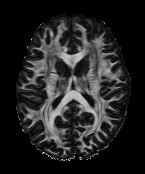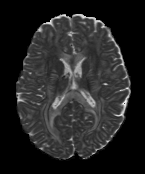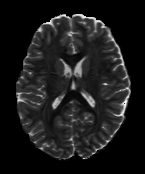 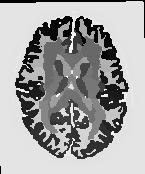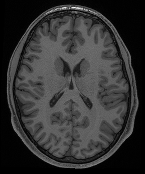 

In [6]:
data = Project_Fn_Utils.load_data_1(num_rows_to_display = 1)
train_data = np.concatenate(data[:3],axis=0)
test_data = data[-1]

Data from /Users/bhavanik/Desktop/FAU Study/Semester 4/Project Detectibility Index/data/dti/sampledata107725.csv:
[[1.077250e+05 7.300000e+01 1.230000e+02 6.300000e+01 7.041184e+02
  2.424968e-01 6.678018e-04 8.039927e-04 5.997064e-04 2.000000e+00]]


Data from /Users/bhavanik/Desktop/FAU Study/Semester 4/Project Detectibility Index/data/dti/sampledata112314.csv:
[[1.123140e+05 7.300000e+01 8.500000e+01 6.300000e+01 7.827678e+02
  3.381405e-01 9.059209e-04 1.261528e-03 7.281175e-04 1.000000e+00]]


Data from /Users/bhavanik/Desktop/FAU Study/Semester 4/Project Detectibility Index/data/dti/sampledata105620.csv:
[[1.056200e+05 7.300000e+01 1.000000e+02 7.100000e+01 8.332361e+02
  3.472693e-01 9.710606e-04 1.376888e-03 7.681468e-04 1.000000e+00]]


Data from /Users/bhavanik/Desktop/FAU Study/Semester 4/Project Detectibility Index/data/dti/sampledata100206.csv:
[[1.002060e+05 7.300000e+01 9.000000e+01 6.500000e+01 8.977018e+02
  2.183588e-01 1.066592e-03 1.328058e-03 9.358592e-04 1.000000e

#### 1.1.2.	Features Selection
  


In [7]:

# input_train, label_train, input_test, label_test
input_train= train_data[:,4:9].astype(float)
label_train= train_data[:,-1]- 1
input_test= test_data[:,4:9].astype(float)
label_test= test_data[:,-1] - 1
print(input_test.shape,input_train.shape)


nSamples = np.size(input_train, axis=0)
nSamples_test = np.size(input_test  ,axis=0)
nClasses = len(set(label_train))
nFeatures = np.size(input_train  ,axis=1)

print(f"Number of samples in training set: {nSamples}")
print(f"Number of samples in test set: {nSamples_test}")
print(f"Number of features: {nFeatures}")
print(f"Number of classes: {nClasses}")

(6145, 5) (17554, 5)
Number of samples in training set: 17554
Number of samples in test set: 6145
Number of features: 5
Number of classes: 3


####  1.1.3.	Training data
- Normalize
  - Use the same normalization factor for the same feature. 

In [8]:

for n in range(nFeatures):
    norm_factor = np.max(input_train[:,n])
    input_train[:,n]= input_train[:,n]/norm_factor
    input_test[:,n]= input_test[:,n] / norm_factor

- Separate training (0.8) and validation (0.2) set.


In [9]:
split_ratio = 0.8
setsize_train = np.ceil(nSamples*split_ratio).astype(int)
x_train = input_train[:setsize_train, :] 
y_train = label_train[:setsize_train]
x_val = input_train[setsize_train:, :]
y_val = label_train[setsize_train:]
print('Training set size is %d',x_train.shape,x_val.shape,y_train.shape,y_val.shape)

Training set size is %d (14044, 5) (3510, 5) (14044,) (3510,)


In [10]:

batch_size= 512

x_train=torch.Tensor(x_train).float().to(DEVICE)
y_train = torch.Tensor(y_train).long().to(DEVICE)
x_val=torch.Tensor(x_val).float().to(DEVICE)
y_val = torch.Tensor(y_val).long().to(DEVICE)
x_test=torch.Tensor(input_test).float().to(DEVICE)
y_test = torch.Tensor(label_test).long().to(DEVICE)
print(x_test.shape,y_test.shape)
dataset_train = data_utils.TensorDataset(x_train,y_train)
dataloader_train = data_utils.DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
dataset_val = data_utils.TensorDataset(x_val,y_val)
dataloader_val = data_utils.DataLoader(dataset_val,batch_size=batch_size,shuffle=True)
dataset_test = data_utils.TensorDataset(x_test,y_test)
dataloader_test = data_utils.DataLoader(dataset_test,batch_size=batch_size,shuffle=True)

torch.Size([6145, 5]) torch.Size([6145])


In [11]:
#Data Augmentation Technique to improve accuracy and robustness of the model
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    
    # Add more transformations as needed
])

# Apply data augmentation to the training dataset
dataset_train = data_utils.TensorDataset(torch.Tensor(x_train).float(), torch.Tensor(y_train).long())
dataset_train_augmented = data_utils.TensorDataset(
    torch.Tensor(x_train).float(),
    torch.Tensor(y_train).long()
)

#the dataset with a lambda function to apply the transformations
dataset_train_augmented.transform = transforms.Lambda(lambda sample: (data_transform(sample[0]), sample[1]))
dataloader_train_augmented = data_utils.DataLoader(dataset_train_augmented, batch_size=batch_size, shuffle=True)

#### 1.2. A fully connected Feed forward neural network 
-	The number of features for hidden layers:100
-	The number of FC layers: 3
-	Activation function: ReLU


In [12]:

nElements = 100
nLayers = 3

Layers = []
Layers.append(nn.Linear(nFeatures,nElements,bias= True))
Layers.append(nn.ReLU())

for i in range(nLayers):
    Layers.append(nn.Linear(nElements,nElements,bias=True))
    Layers.append(nn.ReLU())

Layers.append(nn.Linear(nElements,nClasses,bias=True))
model = nn.Sequential(*Layers)
model = model.to(DEVICE)
print(model)

Sequential(
  (0): Linear(in_features=5, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Linear(in_features=100, out_features=3, bias=True)
)


#### 1.3.A loss function and an optimizer.
- Loss function: Cross entropy loss
- Optimizer: Adam optimizer
  - learning rate: Scheduler
  

In [13]:

criterion= nn.CrossEntropyLoss()
#L2 regularization to prevent overfitting
optimizer = torch.optim.Adam(model.parameters())

#### 1.4. Define a trainer function.


In [14]:
for x,l in dataloader_train:
    out = model(x)
    print(x.shape,l.shape,out.shape)
    break

torch.Size([512, 5]) torch.Size([512]) torch.Size([512, 3])


In [15]:
def trainer(
        model,
        criterion,
        optimizer, 
        dataloader_train,
        dataloader_val,
        num_epochs: int = 30,
        
):
    '''
    Trains a model and returns the training and validation loss and accuracy.

    Args:
        model:              The model to train.
        criterion:          The loss function.
        optimizer:          The optimizer.
        dataloader_train:   The training data.
        dataloader_val:     The validation data.
        num_epochs:         Number of epochs to train for.

    Returns:
        loss_train:         Training loss for each epoch.
        acc_train:          Training accuracy for each epoch.
        loss_val:           Validation loss for each epoch.
        acc_val:            Validation accuracy for each epoch.
    '''
    loss_train = np.zeros(num_epochs)
    acc_train = np.zeros(num_epochs)
    loss_val = np.zeros(num_epochs)
    acc_val = np.zeros(num_epochs)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    max_epochs = 100
    early_stop_counter = 0
    early_stop_patience = 10 # Number of epochs to wait for improvement

    best_val_loss = float('inf')
    with tqdm(total=num_epochs, unit='Epoch', leave=True) as pbar:
        for epoch in range(num_epochs):
            # Training
            running_loss = 0.0
            running_acc = 0

            model.train()  # Set the model to train mode
            for local_batch, local_labels in dataloader_train:
              
                local_batch, local_labels = local_batch.to(DEVICE), local_labels.to(DEVICE)
                
                out = model(local_batch)
                
                loss = criterion(out, local_labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = torch.max(out.data, 1)
                
                running_acc += (torch.sum(local_labels == predicted).item() / local_labels.size(0))

            loss_train[epoch] = running_loss / len(dataloader_train)
            acc_train[epoch] = running_acc / len(dataloader_train)

            # Validation
            running_loss = 0.0
            running_acc = 0
            model.eval()
            with torch.no_grad():
                for local_batch, local_labels in dataloader_val:            
                    
                    local_batch, local_labels = local_batch.to(DEVICE), local_labels.to(DEVICE)

                    out_val = model(local_batch)
                    loss = criterion(out_val, local_labels)
                    running_loss += loss.item()
                    _, predicted_val = torch.max(out_val.data, 1)
                    running_acc += (torch.sum(local_labels == predicted_val).item() / local_labels.size(0))

            loss_val[epoch] = running_loss / len(dataloader_val)
            acc_val[epoch] = running_acc / len(dataloader_val)

            # Learning rate scheduling step
            scheduler.step()

            # Early stopping logic
            if loss_val[epoch] < best_val_loss:
                best_val_loss = loss_val[epoch]
                early_stop_counter = 0
                # Save your model if you want to keep the best model
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                early_stop_counter += 1

            if early_stop_counter >= early_stop_patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

            # Update progress bar
            pbar.set_description(desc=f"Epoch {epoch: 3d}")
            pbar.set_postfix({"train loss": f"{loss_train[epoch]: .3f}",
                            "train acc": f"{acc_train[epoch]: .3f}",
                            "val loss": f"{loss_val[epoch]: .3f}",
                            "val acc": f"{acc_val[epoch]: .3f}"})
            pbar.update()
        
    return loss_train, acc_train, loss_val, acc_val


#### 1.5.	Train the network.
  - Epochs: 30


In [16]:
torch.manual_seed(123)  # for reproducibility
epochs = 30
loss_train, acc_train, loss_val, acc_val = trainer(model,criterion,optimizer,dataloader_train_augmented,dataloader_val, num_epochs=epochs)

  0%|          | 0/30 [00:00<?, ?Epoch/s]

Early stopping at epoch 27


## Model Evaluation

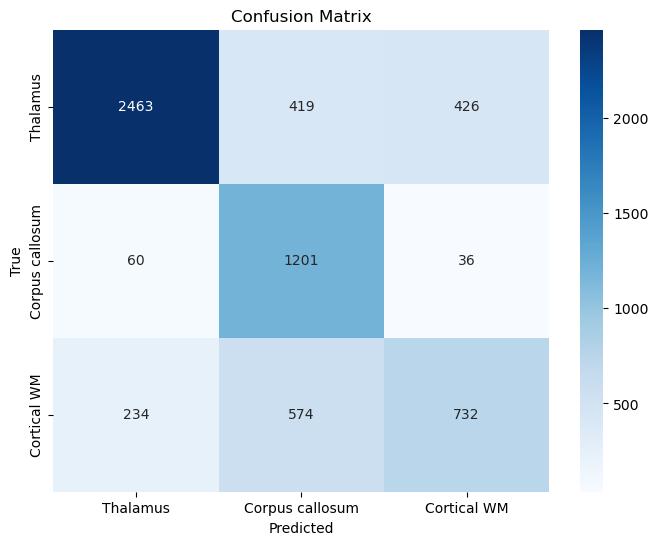

Test Accuracy: 0.7153783563873067


In [17]:
def calculate_confusion_matrix(model, dataloader, num_classes):
    model.eval()
    
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for local_batch, local_labels in dataloader:
            local_batch, local_labels = local_batch.to(DEVICE), local_labels.to(DEVICE)
            outputs = model(local_batch)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(local_labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy()) 
    Cf = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return Cf


Cf=calculate_confusion_matrix(model, dataloader_test , num_classes=3)
plt.figure(figsize=(8, 6))
sns.heatmap(Cf, annot=True, fmt='d', cmap='Blues', xticklabels=['Thalamus','Corpus callosum' ,'Cortical WM'], yticklabels=['Thalamus','Corpus callosum' ,'Cortical WM'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#Testing our model
model.eval()


correct = 0
total = 0

# Iterate over the test dataset
with torch.no_grad():
    for inputs, labels in dataloader_test:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = correct / total

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy}')

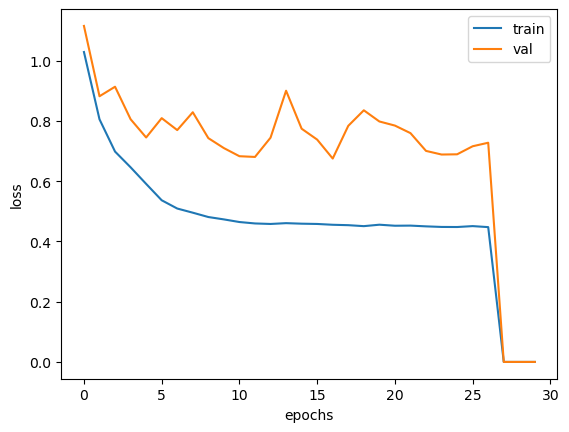

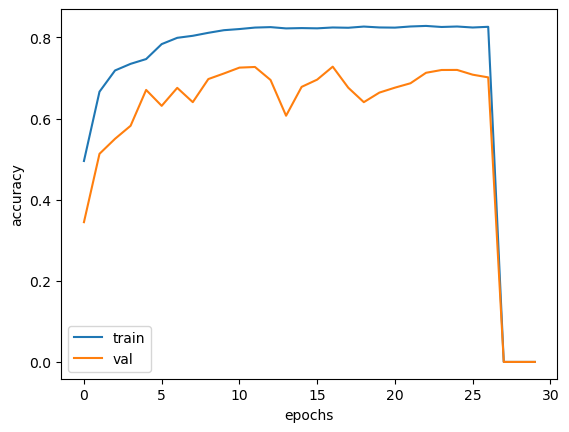

In [18]:
Project_Fn_Utils.plot([loss_train,loss_val],['train','val'],xlabel="epochs",ylabel="loss")
Project_Fn_Utils.plot([acc_train,acc_val],['train','val'],smoothing=1,xlabel='epochs',ylabel="accuracy")

##  2.CNN Implementation


In [19]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        self.maxpool3 = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        self.maxpool4 = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 3)  

    def forward(self, x):
        x = x.unsqueeze(1)
        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.flatten(x)
        x = self.fc1(x)

        return x


In [20]:
print("CNN4layers_FC")
print(f"The number of parameters: {sum(p.numel() for p in CNN().parameters() if p.requires_grad)}")
print(CNN())
print('==========================================')


CNN4layers_FC
The number of parameters: 131139
CNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu2): ReLU()
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu3): ReLU()
  (conv4): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu4): ReLU()
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (maxpool3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (maxpool4): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=512, out_features=3, bias=True)
)


In [21]:
def trainer(
        model,
        criterion,
        optimizer, 
        dataloader_train,
        dataloader_val,
        num_epochs: int = 30,
        
):
    '''
    Trains a model and returns the training and validation loss and accuracy.

    Args:
        model:              The model to train.
        criterion:          The loss function.
        optimizer:          The optimizer.
        dataloader_train:   The training data.
        dataloader_val:     The validation data.
        num_epochs:         Number of epochs to train for.

    Returns:
        loss_train:         Training loss for each epoch.
        acc_train:          Training accuracy for each epoch.
        loss_val:           Validation loss for each epoch.
        acc_val:            Validation accuracy for each epoch.
    '''
    loss_train = np.zeros(num_epochs)
    acc_train = np.zeros(num_epochs)
    loss_val = np.zeros(num_epochs)
    acc_val = np.zeros(num_epochs)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    max_epochs = 100
    early_stop_counter = 0
    early_stop_patience = 10 # Number of epochs to wait for improvement

    best_val_loss = float('inf')
    with tqdm(total=num_epochs, unit='Epoch', leave=True) as pbar:
        for epoch in range(num_epochs):
            # Training
            running_loss = 0.0
            running_acc = 0

            model.train()  # Set the model to train mode
            for local_batch, local_labels in dataloader_train:
              
                local_batch, local_labels = local_batch.to(DEVICE), local_labels.to(DEVICE)
                
                out = model(local_batch)
                
                loss = criterion(out, local_labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = torch.max(out.data, 1)
                
                running_acc += (torch.sum(local_labels == predicted).item() / local_labels.size(0))

            loss_train[epoch] = running_loss / len(dataloader_train)
            acc_train[epoch] = running_acc / len(dataloader_train)

            # Validation
            running_loss = 0.0
            running_acc = 0
            model.eval()
            with torch.no_grad():
                for local_batch, local_labels in dataloader_val:            
                    
                    local_batch, local_labels = local_batch.to(DEVICE), local_labels.to(DEVICE)

                    out_val = model(local_batch)
                    loss = criterion(out_val, local_labels)
                    running_loss += loss.item()
                    _, predicted_val = torch.max(out_val.data, 1)
                    running_acc += (torch.sum(local_labels == predicted_val).item() / local_labels.size(0))

            loss_val[epoch] = running_loss / len(dataloader_val)
            acc_val[epoch] = running_acc / len(dataloader_val)

            # Learning rate scheduling step
            scheduler.step()

            '''# Early stopping logic
            if loss_val[epoch] < best_val_loss:
                best_val_loss = loss_val[epoch]
                early_stop_counter = 0
                # Save your model if you want to keep the best model
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                early_stop_counter += 1

            if early_stop_counter >= early_stop_patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break'''

            # Update progress bar
            pbar.set_description(desc=f"Epoch {epoch: 3d}")
            pbar.set_postfix({"train loss": f"{loss_train[epoch]: .3f}",
                            "train acc": f"{acc_train[epoch]: .3f}",
                            "val loss": f"{loss_val[epoch]: .3f}",
                            "val acc": f"{acc_val[epoch]: .3f}"})
            pbar.update()
        
    return loss_train, acc_train, loss_val, acc_val


In [22]:
torch.manual_seed(123)  # for reproducibility

model1 = CNN().to(DEVICE)
optimizer_cnn4_layers = torch.optim.Adam(model1.parameters())
criterion = nn.CrossEntropyLoss()

epochs = 10

loss_train, acc_train, loss_val, acc_val = trainer(model1,criterion,optimizer_cnn4_layers,dataloader_train_augmented,dataloader_val, num_epochs=epochs)




  0%|          | 0/10 [00:00<?, ?Epoch/s]

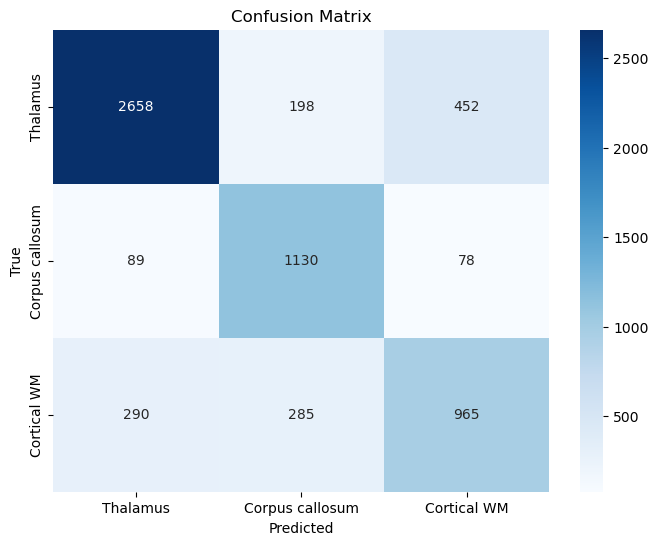

Test Accuracy: 0.7153783563873067


In [23]:
Cf=calculate_confusion_matrix(model1, dataloader_test , num_classes=3)
plt.figure(figsize=(8, 6))
sns.heatmap(Cf, annot=True, fmt='d', cmap='Blues', xticklabels=['Thalamus','Corpus callosum' ,'Cortical WM'], yticklabels=['Thalamus','Corpus callosum' ,'Cortical WM'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Testing our model
model.eval()

correct = 0
total = 0

#Iterate over the test dataset
with torch.no_grad():
    for inputs, labels in dataloader_test:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = correct / total

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy}')

#### 1.6. Evaluation and the training curves of our model.

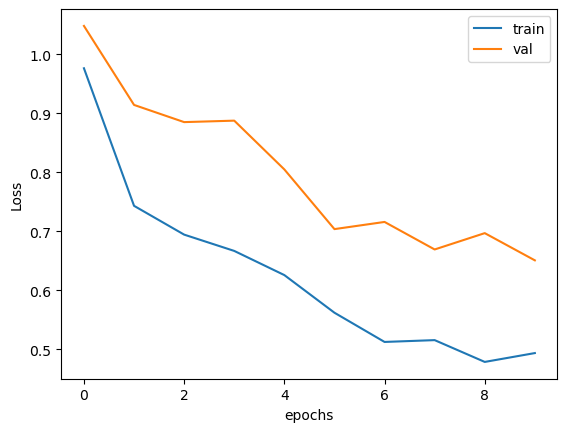

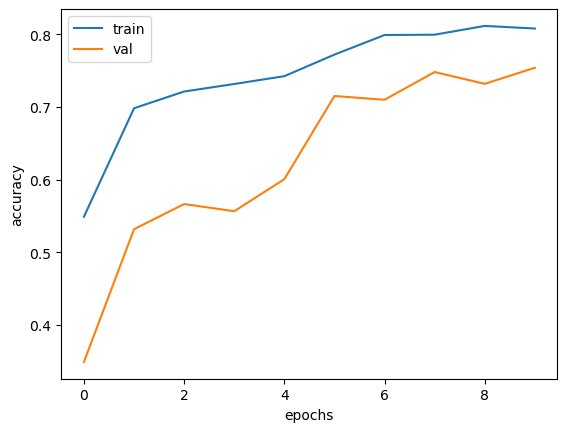

In [24]:
Project_Fn_Utils.plot([loss_train,loss_val],['train','val'],xlabel='epochs',ylabel="Loss")
Project_Fn_Utils.plot([acc_train,acc_val],['train','val'],smoothing=1,xlabel='epochs',ylabel="accuracy")


### 2.4.3.	CNN with 4 layers + global average pooling

In [25]:
import torch.nn as nn

class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        self.global_avgpool = nn.AdaptiveAvgPool1d(1)  # Adjusted to 1D
        self.fc1 = nn.Linear(256, 3)  # Adjusted input size

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool(x)
        x = self.global_avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


In [26]:
print("CNN4layers_global_avg")
print(f"The number of parameters: {sum(p.numel() for p in CNN1().parameters() if p.requires_grad)}")
print(CNN1())

CNN4layers_global_avg
The number of parameters: 130371
CNN1(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu2): ReLU()
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu3): ReLU()
  (conv4): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu4): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (global_avgpool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=256, out_features=3, bias=True)
)


### 2.4.3.	CNN with 4 layers + global average pooling

In [27]:
torch.manual_seed(123)  # for reproducibility
model3 = CNN1().to(DEVICE)
epochs = 9
optimizer_cnn4_layers_global_avg = torch.optim.Adam(model3.parameters())
loss_train, acc_train ,loss_val, acc_val=trainer(model3,criterion,optimizer_cnn4_layers_global_avg,dataloader_train_augmented ,dataloader_val, num_epochs=epochs)
Cf=calculate_confusion_matrix(model3, dataloader_test , num_classes=3)
plt.figure(figsize=(8, 6))
sns.heatmap(Cf, annot=True, fmt='d', cmap='Blues', xticklabels=['Thalamus','Corpus callosum' ,'Cortical WM'], yticklabels=['Thalamus','Corpus callosum' ,'Cortical WM'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

model.eval()


correct = 0
total = 0

# Iterate over the test dataset
with torch.no_grad():
    for inputs, labels in dataloader_test:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = correct / total

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy}')


  0%|          | 0/9 [00:00<?, ?Epoch/s]

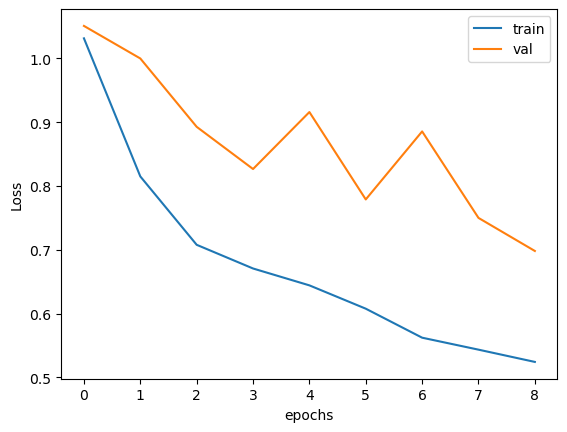

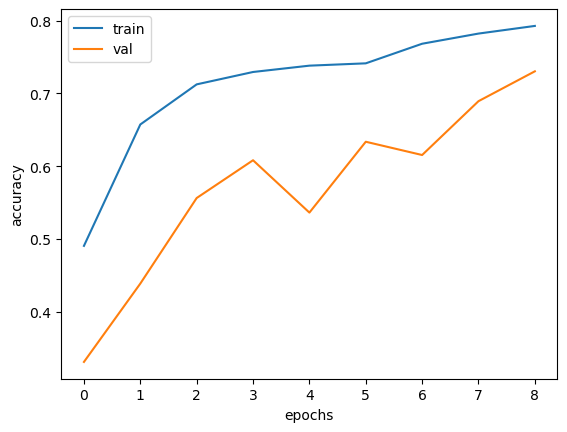

In [ ]:
Project_Fn_Utils.plot([loss_train,loss_val],['train','val'],xlabel='epochs',ylabel="Loss")
Project_Fn_Utils.plot([acc_train,acc_val],['train','val'],smoothing=1,xlabel='epochs',ylabel="accuracy")